### Importing Necessary Libraries

In [1]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [2]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [3]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [4]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [5]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [6]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [7]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [9]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [10]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [11]:
fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg], axis=-1)
fine_tune_data.shape

(16000, 5, 2560)

In [12]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [13]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2560)

In [14]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [15]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2560)

In [16]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [47]:
def ftmodel():
    inputs = Input(shape=(5, 2560))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-FineTune')
    return model1

In [48]:
model1 = ftmodel()
model1.summary()

Model: "RestNet-VGG-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5, 2560)]         0         
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 batch_normalization_3 (Batc  (None, 12800)            51200     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 12800)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6554112   
                                                                 
 batch_normalization_4 (Batc  (None, 512)              2048      
 hNormalization)                              

### Model Training

The fine-tuning will be done on the ResNet+VGG's $2048D+512D$ representation vectors.

In [49]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [50]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-VGG-4P/auto-ResNet-VGG-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [51]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-VGG-4P/resnet-vgg-4p-model-weights")
model1.load_weights('./Models/ResNet-VGG-4P/resnet-vgg-4p-model-weights')

Epoch 1/1000


2022-10-09 12:28:25.116643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.2260 - accuracy: 0.4436

2022-10-09 12:28:26.079700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 63ms/step - loss: 2.2260 - accuracy: 0.4436 - val_loss: 1.9187 - val_accuracy: 0.4300
Epoch 2/1000
19/19 [==============================] - 1s 66ms/step - loss: 1.4259 - accuracy: 0.6031 - val_loss: 1.5587 - val_accuracy: 0.5512
Epoch 3/1000
19/19 [==============================] - 1s 43ms/step - loss: 1.2004 - accuracy: 0.6637 - val_loss: 1.3992 - val_accuracy: 0.6175
Epoch 4/1000
19/19 [==============================] - 1s 43ms/step - loss: 1.0485 - accuracy: 0.7022 - val_loss: 1.3255 - val_accuracy: 0.6488
Epoch 5/1000
19/19 [==============================] - 1s 46ms/step - loss: 0.9426 - accuracy: 0.7280 - val_loss: 1.2725 - val_accuracy: 0.6750
Epoch 6/1000
19/19 [==============================] - 1s 36ms/step - loss: 0.8603 - accuracy: 0.7547 - val_loss: 1.2241 - val_accuracy: 0.6925
Epoch 7/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.7813 - accuracy: 0.7775 - val_loss: 1.1741 - val_accuracy: 0.6962
Epoch 8/1000

19/19 [==============================] - 1s 47ms/step - loss: 0.1440 - accuracy: 0.9776 - val_loss: 0.9341 - val_accuracy: 0.7825
Epoch 59/1000
19/19 [==============================] - 1s 46ms/step - loss: 0.1439 - accuracy: 0.9759 - val_loss: 0.9292 - val_accuracy: 0.7862
Epoch 60/1000
19/19 [==============================] - 1s 49ms/step - loss: 0.1395 - accuracy: 0.9753 - val_loss: 0.9387 - val_accuracy: 0.7850
Epoch 61/1000
19/19 [==============================] - 1s 54ms/step - loss: 0.1355 - accuracy: 0.9784 - val_loss: 0.9531 - val_accuracy: 0.7825
Epoch 62/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.1366 - accuracy: 0.9794 - val_loss: 0.9504 - val_accuracy: 0.7875
Epoch 63/1000
19/19 [==============================] - 1s 40ms/step - loss: 0.1342 - accuracy: 0.9802 - val_loss: 0.9347 - val_accuracy: 0.7850
Epoch 64/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.1376 - accuracy: 0.9778 - val_loss: 0.9381 - val_accuracy: 0.7788
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.1025 - accuracy: 0.9892 - val_loss: 1.0367 - val_accuracy: 0.7763
Epoch 116/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1035 - accuracy: 0.9887 - val_loss: 1.0067 - val_accuracy: 0.7875
Epoch 117/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1017 - accuracy: 0.9885 - val_loss: 1.0164 - val_accuracy: 0.7875
Epoch 118/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.0982 - accuracy: 0.9909 - val_loss: 1.0199 - val_accuracy: 0.7775
Epoch 119/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0996 - accuracy: 0.9903 - val_loss: 0.9824 - val_accuracy: 0.7862
Epoch 120/1000
19/19 [==============================] - 1s 44ms/step - loss: 0.0976 - accuracy: 0.9911 - val_loss: 1.0320 - val_accuracy: 0.7862
Epoch 121/1000
19/19 [==============================] - 1s 49ms/step - loss: 0.0958 - accuracy: 0.9913 - val_loss: 1.0063 - val_ac

19/19 [==============================] - 1s 47ms/step - loss: 0.0897 - accuracy: 0.9932 - val_loss: 1.0378 - val_accuracy: 0.7887
Epoch 172/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0929 - accuracy: 0.9930 - val_loss: 1.0511 - val_accuracy: 0.7862
Epoch 173/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0930 - accuracy: 0.9925 - val_loss: 1.0368 - val_accuracy: 0.7950
Epoch 174/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0916 - accuracy: 0.9930 - val_loss: 1.0514 - val_accuracy: 0.7850
Epoch 175/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0906 - accuracy: 0.9943 - val_loss: 1.0399 - val_accuracy: 0.7950
Epoch 176/1000
19/19 [==============================] - 1s 41ms/step - loss: 0.0950 - accuracy: 0.9929 - val_loss: 1.0599 - val_accuracy: 0.7900
Epoch 177/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0943 - accuracy: 0.9921 - val_loss: 1.0579 - val_accuracy: 0.7850


19/19 [==============================] - 0s 19ms/step - loss: 0.0947 - accuracy: 0.9918 - val_loss: 1.0775 - val_accuracy: 0.7850
Epoch 228/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0916 - accuracy: 0.9933 - val_loss: 1.0629 - val_accuracy: 0.7862
Epoch 229/1000
19/19 [==============================] - 1s 25ms/step - loss: 0.0912 - accuracy: 0.9936 - val_loss: 1.0779 - val_accuracy: 0.7900
Epoch 230/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0934 - accuracy: 0.9928 - val_loss: 1.0866 - val_accuracy: 0.7862
Epoch 231/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0938 - accuracy: 0.9933 - val_loss: 1.0963 - val_accuracy: 0.7875
Epoch 232/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.0935 - accuracy: 0.9934 - val_loss: 1.0912 - val_accuracy: 0.7887
Epoch 233/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0913 - accuracy: 0.9940 - val_loss: 1.0956 - val_accuracy: 0.7875


19/19 [==============================] - 1s 37ms/step - loss: 0.0936 - accuracy: 0.9939 - val_loss: 1.1343 - val_accuracy: 0.7862
Epoch 284/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0930 - accuracy: 0.9934 - val_loss: 1.1093 - val_accuracy: 0.7925
Epoch 285/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.0937 - accuracy: 0.9936 - val_loss: 1.1091 - val_accuracy: 0.7875
Epoch 286/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0926 - accuracy: 0.9945 - val_loss: 1.0941 - val_accuracy: 0.7912
Epoch 287/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0951 - accuracy: 0.9930 - val_loss: 1.1170 - val_accuracy: 0.7950
Epoch 288/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0941 - accuracy: 0.9933 - val_loss: 1.1188 - val_accuracy: 0.7912
Epoch 289/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0949 - accuracy: 0.9928 - val_loss: 1.0774 - val_accuracy: 0.8025


19/19 [==============================] - 0s 24ms/step - loss: 0.0955 - accuracy: 0.9938 - val_loss: 1.1209 - val_accuracy: 0.7900
Epoch 340/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0932 - accuracy: 0.9945 - val_loss: 1.1232 - val_accuracy: 0.7887
Epoch 341/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0939 - accuracy: 0.9942 - val_loss: 1.0923 - val_accuracy: 0.7937
Epoch 342/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0951 - accuracy: 0.9941 - val_loss: 1.1179 - val_accuracy: 0.7900
Epoch 343/1000
19/19 [==============================] - 1s 42ms/step - loss: 0.0949 - accuracy: 0.9938 - val_loss: 1.1401 - val_accuracy: 0.7887
Epoch 344/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0957 - accuracy: 0.9934 - val_loss: 1.1067 - val_accuracy: 0.7887
Epoch 345/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0961 - accuracy: 0.9936 - val_loss: 1.1056 - val_accuracy: 0.7875


19/19 [==============================] - 1s 35ms/step - loss: 0.0952 - accuracy: 0.9943 - val_loss: 1.1551 - val_accuracy: 0.7912
Epoch 396/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0965 - accuracy: 0.9938 - val_loss: 1.1579 - val_accuracy: 0.7825
Epoch 397/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0956 - accuracy: 0.9942 - val_loss: 1.1619 - val_accuracy: 0.7862
Epoch 398/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0941 - accuracy: 0.9947 - val_loss: 1.1909 - val_accuracy: 0.7875
Epoch 399/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.0938 - accuracy: 0.9948 - val_loss: 1.1823 - val_accuracy: 0.7800
Epoch 400/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0941 - accuracy: 0.9943 - val_loss: 1.1585 - val_accuracy: 0.7875
Epoch 401/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.0938 - accuracy: 0.9949 - val_loss: 1.1246 - val_accuracy: 0.7987


19/19 [==============================] - 1s 33ms/step - loss: 0.0984 - accuracy: 0.9936 - val_loss: 1.2281 - val_accuracy: 0.7738
Epoch 452/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0968 - accuracy: 0.9934 - val_loss: 1.2013 - val_accuracy: 0.7962
Epoch 453/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.0951 - accuracy: 0.9945 - val_loss: 1.2124 - val_accuracy: 0.7962
Epoch 454/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.0958 - accuracy: 0.9947 - val_loss: 1.2017 - val_accuracy: 0.7862
Epoch 455/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.0974 - accuracy: 0.9947 - val_loss: 1.1801 - val_accuracy: 0.7975
Epoch 456/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0980 - accuracy: 0.9942 - val_loss: 1.1955 - val_accuracy: 0.8000
Epoch 457/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0961 - accuracy: 0.9943 - val_loss: 1.1793 - val_accuracy: 0.8012


19/19 [==============================] - 0s 21ms/step - loss: 0.0956 - accuracy: 0.9951 - val_loss: 1.2044 - val_accuracy: 0.7850
Epoch 508/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0990 - accuracy: 0.9937 - val_loss: 1.2163 - val_accuracy: 0.7850
Epoch 509/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.0966 - accuracy: 0.9940 - val_loss: 1.2173 - val_accuracy: 0.7775
Epoch 510/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0953 - accuracy: 0.9945 - val_loss: 1.1918 - val_accuracy: 0.7900
Epoch 511/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.0966 - accuracy: 0.9943 - val_loss: 1.1887 - val_accuracy: 0.7850
Epoch 512/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0958 - accuracy: 0.9953 - val_loss: 1.1746 - val_accuracy: 0.7912
Epoch 513/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0946 - accuracy: 0.9947 - val_loss: 1.1950 - val_accuracy: 0.7912


19/19 [==============================] - 0s 20ms/step - loss: 0.0959 - accuracy: 0.9945 - val_loss: 1.1984 - val_accuracy: 0.7962
Epoch 564/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0980 - accuracy: 0.9951 - val_loss: 1.1993 - val_accuracy: 0.7975
Epoch 565/1000
19/19 [==============================] - 1s 34ms/step - loss: 0.0970 - accuracy: 0.9943 - val_loss: 1.1708 - val_accuracy: 0.8062
Epoch 566/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0983 - accuracy: 0.9940 - val_loss: 1.1739 - val_accuracy: 0.7987
Epoch 567/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.0967 - accuracy: 0.9945 - val_loss: 1.1562 - val_accuracy: 0.8025
Epoch 568/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0981 - accuracy: 0.9945 - val_loss: 1.1440 - val_accuracy: 0.7912
Epoch 569/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0971 - accuracy: 0.9945 - val_loss: 1.1268 - val_accuracy: 0.7975


19/19 [==============================] - 0s 23ms/step - loss: 0.0962 - accuracy: 0.9952 - val_loss: 1.2118 - val_accuracy: 0.7912
Epoch 620/1000
19/19 [==============================] - 1s 26ms/step - loss: 0.0953 - accuracy: 0.9955 - val_loss: 1.2098 - val_accuracy: 0.7975
Epoch 621/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0968 - accuracy: 0.9948 - val_loss: 1.2090 - val_accuracy: 0.7937
Epoch 622/1000
19/19 [==============================] - 1s 26ms/step - loss: 0.0968 - accuracy: 0.9950 - val_loss: 1.2009 - val_accuracy: 0.7850
Epoch 623/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0964 - accuracy: 0.9951 - val_loss: 1.2079 - val_accuracy: 0.7800
Epoch 624/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0964 - accuracy: 0.9951 - val_loss: 1.1826 - val_accuracy: 0.7837
Epoch 625/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0962 - accuracy: 0.9949 - val_loss: 1.2095 - val_accuracy: 0.7788


19/19 [==============================] - 1s 32ms/step - loss: 0.0955 - accuracy: 0.9953 - val_loss: 1.2148 - val_accuracy: 0.8050
Epoch 676/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0956 - accuracy: 0.9953 - val_loss: 1.2027 - val_accuracy: 0.8037
Epoch 677/1000
19/19 [==============================] - 1s 29ms/step - loss: 0.0955 - accuracy: 0.9951 - val_loss: 1.1855 - val_accuracy: 0.7925
Epoch 678/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0957 - accuracy: 0.9952 - val_loss: 1.1899 - val_accuracy: 0.7875
Epoch 679/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.0939 - accuracy: 0.9959 - val_loss: 1.2012 - val_accuracy: 0.7887
Epoch 680/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0947 - accuracy: 0.9954 - val_loss: 1.2232 - val_accuracy: 0.7837
Epoch 681/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0960 - accuracy: 0.9950 - val_loss: 1.2287 - val_accuracy: 0.8050


19/19 [==============================] - 0s 21ms/step - loss: 0.0950 - accuracy: 0.9958 - val_loss: 1.2426 - val_accuracy: 0.7925
Epoch 732/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0957 - accuracy: 0.9957 - val_loss: 1.2185 - val_accuracy: 0.7962
Epoch 733/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0939 - accuracy: 0.9957 - val_loss: 1.2114 - val_accuracy: 0.7925
Epoch 734/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0940 - accuracy: 0.9955 - val_loss: 1.2004 - val_accuracy: 0.7962
Epoch 735/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0939 - accuracy: 0.9957 - val_loss: 1.2317 - val_accuracy: 0.7887
Epoch 736/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0941 - accuracy: 0.9961 - val_loss: 1.2355 - val_accuracy: 0.7875
Epoch 737/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.0969 - accuracy: 0.9943 - val_loss: 1.2047 - val_accuracy: 0.7962


19/19 [==============================] - 0s 19ms/step - loss: 0.0958 - accuracy: 0.9952 - val_loss: 1.1868 - val_accuracy: 0.8000
Epoch 788/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.1001 - accuracy: 0.9945 - val_loss: 1.2219 - val_accuracy: 0.7987
Epoch 789/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0968 - accuracy: 0.9949 - val_loss: 1.2309 - val_accuracy: 0.7950
Epoch 790/1000
19/19 [==============================] - 1s 35ms/step - loss: 0.0989 - accuracy: 0.9939 - val_loss: 1.1990 - val_accuracy: 0.8000
Epoch 791/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0968 - accuracy: 0.9951 - val_loss: 1.1596 - val_accuracy: 0.7937
Epoch 792/1000
19/19 [==============================] - 0s 20ms/step - loss: 0.0965 - accuracy: 0.9951 - val_loss: 1.1688 - val_accuracy: 0.7962
Epoch 793/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.0946 - accuracy: 0.9956 - val_loss: 1.1718 - val_accuracy: 0.7962


19/19 [==============================] - 0s 21ms/step - loss: 0.0980 - accuracy: 0.9949 - val_loss: 1.2058 - val_accuracy: 0.7962
Epoch 844/1000
19/19 [==============================] - 0s 26ms/step - loss: 0.0930 - accuracy: 0.9964 - val_loss: 1.2216 - val_accuracy: 0.7950
Epoch 845/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0981 - accuracy: 0.9955 - val_loss: 1.2394 - val_accuracy: 0.7925
Epoch 846/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.1009 - accuracy: 0.9947 - val_loss: 1.2331 - val_accuracy: 0.7900
Epoch 847/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0958 - accuracy: 0.9947 - val_loss: 1.2303 - val_accuracy: 0.7987
Epoch 848/1000
19/19 [==============================] - 0s 25ms/step - loss: 0.0952 - accuracy: 0.9951 - val_loss: 1.2138 - val_accuracy: 0.7975
Epoch 849/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0965 - accuracy: 0.9949 - val_loss: 1.1979 - val_accuracy: 0.8075


19/19 [==============================] - 0s 20ms/step - loss: 0.0945 - accuracy: 0.9953 - val_loss: 1.1873 - val_accuracy: 0.7950
Epoch 900/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0921 - accuracy: 0.9963 - val_loss: 1.2088 - val_accuracy: 0.7900
Epoch 901/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0969 - accuracy: 0.9957 - val_loss: 1.1884 - val_accuracy: 0.7912
Epoch 902/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0938 - accuracy: 0.9953 - val_loss: 1.1722 - val_accuracy: 0.7937
Epoch 903/1000
19/19 [==============================] - 1s 33ms/step - loss: 0.0968 - accuracy: 0.9936 - val_loss: 1.1908 - val_accuracy: 0.7862
Epoch 904/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0940 - accuracy: 0.9953 - val_loss: 1.2206 - val_accuracy: 0.7912
Epoch 905/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.0951 - accuracy: 0.9960 - val_loss: 1.2281 - val_accuracy: 0.7925


19/19 [==============================] - 0s 22ms/step - loss: 0.0971 - accuracy: 0.9943 - val_loss: 1.1985 - val_accuracy: 0.7950
Epoch 956/1000
19/19 [==============================] - 1s 27ms/step - loss: 0.0987 - accuracy: 0.9938 - val_loss: 1.2387 - val_accuracy: 0.7975
Epoch 957/1000
19/19 [==============================] - 1s 37ms/step - loss: 0.0963 - accuracy: 0.9949 - val_loss: 1.2450 - val_accuracy: 0.8012
Epoch 958/1000
19/19 [==============================] - 1s 31ms/step - loss: 0.0980 - accuracy: 0.9946 - val_loss: 1.2632 - val_accuracy: 0.7950
Epoch 959/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0956 - accuracy: 0.9949 - val_loss: 1.2499 - val_accuracy: 0.7937
Epoch 960/1000
19/19 [==============================] - 0s 21ms/step - loss: 0.0949 - accuracy: 0.9958 - val_loss: 1.2233 - val_accuracy: 0.7862
Epoch 961/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.0950 - accuracy: 0.9953 - val_loss: 1.2156 - val_accuracy: 0.7925


In [52]:
model1.load_weights('./Models/ResNet-VGG-4P/auto-ResNet-VGG-FT-model-weight')

In [53]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

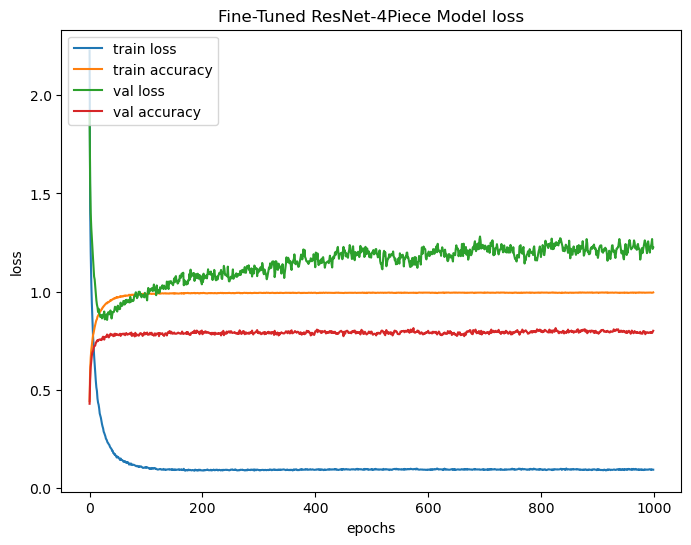

In [54]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [55]:
train_preds = model1.predict(fine_tune_data_train)

  3/475 [..............................] - ETA: 12s 

2022-10-09 12:37:32.384101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 3s 6ms/step


In [56]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [57]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [58]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [59]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [60]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.997959,1.000000,0.998979,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [61]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 6ms/step


In [62]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [63]:
test_pred_labels

array([11,  8,  6,  1,  1,  9, 13, 12, 14,  1,  6, 15,  0, 14, 13, 11,  0,
        9,  6,  1,  8, 14,  3, 12,  6,  0,  3,  5,  3,  3, 11,  1,  9,  2,
        1,  8,  4,  7,  1,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12,  0, 11, 14, 11,  6,  9,  2, 15, 13, 11, 11,  6, 12,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  0, 12, 12,  9,
        8,  1, 13, 13, 13, 10, 11,  4, 10,  1, 10, 11,  8, 13, 10,  3, 11,
        5,  9,  1, 14,  8,  2,  1,  5,  7,  5,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0, 12, 13,  5, 10, 12,  0, 11,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  4, 12,  8,  5,  8,  9,  2, 13,  0, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 11, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 11, 11,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8, 10,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  1

In [64]:
np.sum(test_pred_labels == test_labels['label'])

642

In [65]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
12,179,./Data/train/train/179.tif,7
14,203,./Data/train/train/203.tif,1
19,372,./Data/train/train/372.tif,13
...,...,...,...
763,15318,./Data/train/train/15318.tif,1
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
780,15571,./Data/train/train/15571.tif,14


In [66]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.721311,0.814815,0.765217,54
1,0.596154,0.704545,0.645833,44
2,0.923077,0.837209,0.878049,43
3,0.895833,0.934783,0.914894,46
4,0.888889,0.888889,0.888889,36
5,0.673913,0.620000,0.645833,50
6,0.930233,0.869565,0.898876,46
7,0.869565,0.769231,0.816327,52
8,0.854839,0.981481,0.913793,54
9,0.812500,0.829787,0.821053,47


In [67]:
np.mean(fscore)

0.802408227663826

#### On Validation Data

Generating Predictions for the Validation Set

In [68]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [69]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [70]:
fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [71]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg], axis=-1)
fine_tune_data_validation.shape

(900, 5, 2560)

In [72]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 4ms/step


2022-10-09 12:37:53.119879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [73]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [74]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,5


In [75]:
submission_data.to_csv('./Submissions/submission-resnet-vgg-4p.csv', index=False)